In [1]:
# General Imports
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Building Model
from keras.utils import plot_model
from tensorflow.keras import models
from tensorflow.keras.layers import BatchNormalization, Flatten, Dropout, Dense, Conv2D 
from tensorflow.keras.layers import MaxPooling2D

# Training Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint


# Data Processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import load_img

Data imported

In [2]:
# Function for importing data           
def get_data_labels(directory, shuffle=True, random_state=0):
    """
    Function used for going into the main training directory
    whose directory has sub-class-types.
    """
    from sklearn.utils import shuffle
    import os

    # Lists to store data and labels
    data_path = []
    data_labels = []
    
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)

        # Avoid MacOS storing path
        if not os.path.isdir(label_dir):
            continue

        # Going into each folder and getting image path
        for image in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image)
            data_path.append(image_path)
            data_labels.append(label)
            
    if shuffle:
        data_path, data_labels = shuffle(data_path, data_labels, random_state=random_state)
            
    return data_path, data_labels

In [5]:
# Setting up file paths for training and testing
data_path = r"C:\Users\komal\Desktop\brain tumor\brain tumor dataset"
normal = data_path + r'/Testing'
tumor = data_path + r'/Training'

# Getting data using above function
normal_paths, normal_labels = get_data_labels(normal, shuffle=False)
tumor_paths, tumor_labels = get_data_labels(tumor, shuffle=False)

# Printing Normal and tumor sample sizes
print('Normal Brain Scans')
print(f'Number of Paths: {len(normal_paths)}')
print(f'Number of Labels: {len(normal_labels)}')
print('\nTumor Brain Scans')
print(f'Number of Paths: {len(tumor_paths)}')
print(f'Number of Labels: {len(tumor_labels)}')

Normal Brain Scans
Number of Paths: 1311
Number of Labels: 1311

Tumor Brain Scans
Number of Paths: 5712
Number of Labels: 5712


In [6]:
print(f'Some Tumor labels: {tumor_labels[500:505]}')

# Remove the word "tumor" from each element in the list
tumor_labels = [path.replace('_tumor', '').title() for path in tumor_labels]

# Print the cleaned paths
print(f'Some Tumor labels: {tumor_labels[500:505]}')

Some Tumor labels: ['meningioma', 'pituitary', 'pituitary', 'pituitary', 'notumor']
Some Tumor labels: ['Meningioma', 'Pituitary', 'Pituitary', 'Pituitary', 'Notumor']


Data processing

In [7]:
from sklearn.model_selection import train_test_split

# Merging paths and labels
paths = normal_paths + tumor_paths
labels = normal_labels + tumor_labels

# Split the data into training and testing sets
train_paths, test_paths, train_labels, test_labels = train_test_split(
    paths,labels, test_size=0.35, random_state=42
)

# Create DataFrames for training and testing data
train_df = pd.DataFrame({'path': train_paths, 'label': train_labels})
test_df = pd.DataFrame({'path': test_paths, 'label': test_labels})

In [8]:
# 2 values in train_df and 1 in test_df have a un-defined tumor value
train_df = train_df[train_df['label'] != 'Tumor']
test_df = test_df[test_df['label'] != 'Tumor']

In [9]:
class_type = pd.unique(train_df['label'])
N_TYPES = len(class_type)

print(f'Classes: {class_type} and length {N_TYPES}')

Classes: ['Pituitary' 'pituitary' 'Meningioma' 'glioma' 'meningioma' 'Notumor'
 'notumor' 'Glioma'] and length 8


In [22]:
#convert labels to title case
train_df['label'] = train_df['label'].str.title()
test_df['label'] = test_df['label'].str.title()
# Mapping dictionary
tumor_classes = {'Notumor': 0,
                 'Glioma': 1,
                 'Meningioma': 2,
                 'Pituitary': 3

}


# Apply mapping to both DataFrames
train_df['label_encoded'] = train_df['label'].map(tumor_classes)
test_df['label_encoded'] = test_df['label'].map(tumor_classes)


In [23]:
display(train_df)
display(test_df)

,path,label,label_encoded
0,C:\Users\komal\Desktop\brain tumor\brain tumor...,Pituitary,3
1,C:\Users\komal\Desktop\brain tumor\brain tumor...,Pituitary,3
2,C:\Users\komal\Desktop\brain tumor\brain tumor...,Pituitary,3
3,C:\Users\komal\Desktop\brain tumor\brain tumor...,Meningioma,2
4,C:\Users\komal\Desktop\brain tumor\brain tumor...,Glioma,1
...,...,...,...
4559,C:\Users\komal\Desktop\brain tumor\brain tumor...,Notumor,0
4560,C:\Users\komal\Desktop\brain tumor\brain tumor...,Notumor,0
4561,C:\Users\komal\Desktop\brain tumor\brain tumor...,Notumor,0
4562,C:\Users\komal\Desktop\brain tumor\brain tumor...,Glioma,1


,path,label,label_encoded
0,C:\Users\komal\Desktop\brain tumor\brain tumor...,Glioma,1
1,C:\Users\komal\Desktop\brain tumor\brain tumor...,Notumor,0
2,C:\Users\komal\Desktop\brain tumor\brain tumor...,Pituitary,3
3,C:\Users\komal\Desktop\brain tumor\brain tumor...,Meningioma,2
4,C:\Users\komal\Desktop\brain tumor\brain tumor...,Glioma,1
...,...,...,...
2454,C:\Users\komal\Desktop\brain tumor\brain tumor...,Meningioma,2
2455,C:\Users\komal\Desktop\brain tumor\brain tumor...,Glioma,1
2456,C:\Users\komal\Desktop\brain tumor\brain tumor...,Meningioma,2
2457,C:\Users\komal\Desktop\brain tumor\brain tumor...,Pituitary,3


Data visualisation

x reshaped: (1, 150, 150, 3)


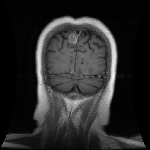

In [24]:
# getting image to test output
im = load_img(train_paths[3], target_size=(150, 150))
im = img_to_array(im)

# Reshape it to (1, 150, 150, 3)
im = np.expand_dims(im, axis=0)
print(f'x reshaped: {im.shape}')

# normilzation tensor
im /= np.max(im) # ~ np.max(img_tensor)

# Convert the array back to the image format
im = array_to_img(im[0])
display(im)

In [25]:
# Function to display a list of images based on the given index
def show_images(paths, label_paths, index_list=range(10), im_size=250, figsize=(12, 8), save=False):
    
    num_images = len(index_list)
    num_rows = (num_images + 3) // 4
    
    fig, ax = plt.subplots(nrows=num_rows, ncols=4, figsize=figsize)
    ax = ax.flatten()

    for i, index in enumerate(index_list):
        if i >= num_images:
            break
        
        image = load_img(paths[index], target_size=(im_size, im_size))
        ax[i].imshow(image)
        ax[i].set_title(f'{index}: {label_paths[index]}')
        ax[i].axis('off')

    plt.tight_layout()
    
    if save:
        plt.savefig('show_image.pdf')
    else:
        plt.show()

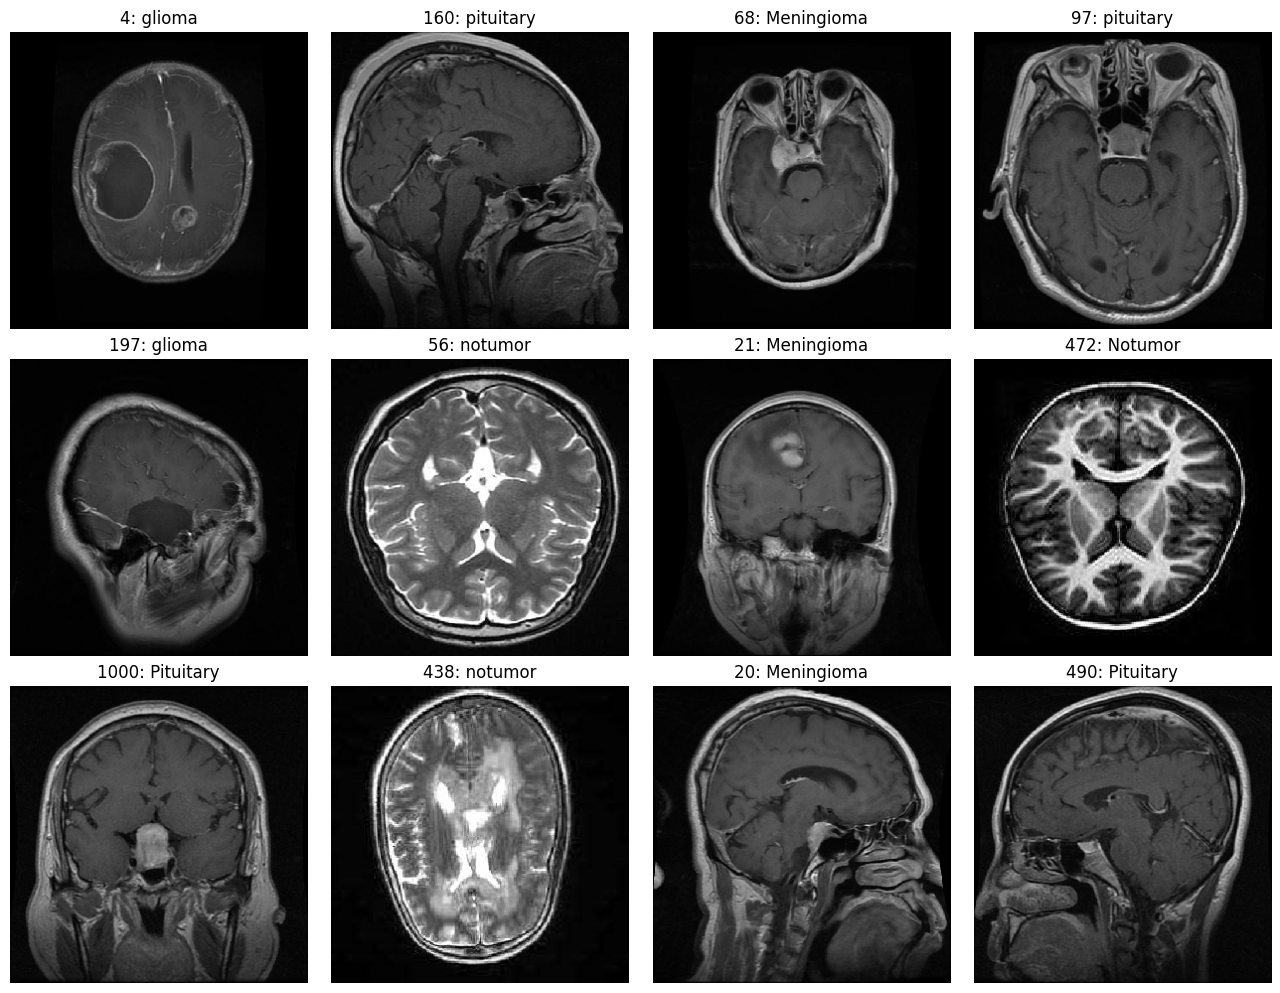

In [27]:
show_images(train_paths, 
            train_labels, 
            index_list=[4, 160, 68, 97,
                        197, 56, 21, 472,
                        1000, 438, 20, 490], 
            im_size=300, 
            figsize=(13,10),
            save=True)

In [28]:
# Image shape: height, width, RBG
image_size = (150, 150)
image_shape = (image_size[0], image_size[1], 1)

# Training parameters
epochs = 10
batch_size = 150

print(f'Image shape: {image_shape}')
print(f'Epochs: {epochs}')
print(f'Batch size: {batch_size}')

Image shape: (150, 150, 1)
Epochs: 10
Batch size: 150


In [29]:
def img_preprocessing(image_path, label_encoded):
    # Read and decode the image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    
    # Convert to grayscale
    img = tf.image.rgb_to_grayscale(img)
    
    # Resize and normalize the image
    img = tf.image.resize(img, size=(150, 150))
    img = img / 255.0
    
    return img, tf.one_hot(label_encoded, depth=N_TYPES)

# Creating dataset loaders with label indices
train_loader = tf.data.Dataset.from_tensor_slices((train_df['path'], train_df['label_encoded']))
train_dataset = (train_loader.map(img_preprocessing
                                 ).batch(batch_size).shuffle(train_df['path'].shape[0]).prefetch(batch_size))

test_loader = tf.data.Dataset.from_tensor_slices((test_df['path'], test_df['label_encoded']))
test_dataset = (test_loader.map(img_preprocessing
                               ).batch(batch_size).shuffle(test_df['path'].shape[0]).prefetch(batch_size))


CNN Model

In [30]:
from tensorflow.keras.optimizers import Adam
# Define the model architecture
model = models.Sequential()

# Convolutional layer 1
model.add(Conv2D(32, (4, 4), activation="relu", input_shape=image_shape))
model.add(MaxPooling2D(pool_size=(3, 3)))

# Convolutional layer 2
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(3, 3)))

# Convolutional layer 3
model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(3, 3))) #

# Convolutional layer 4
model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(Flatten())

# Full connect layers
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5, seed=42))
model.add(Dense(N_TYPES, activation="softmax"))

model.summary()


optimizer = Adam(learning_rate=0.001, beta_1=0.87, beta_2=0.9995)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics= ['accuracy'])

c:\Users\komal\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 147, 147, 32)   │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 13, 13, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 2, 2, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 507,240 (1.93 MB)

 Trainable params: 507,240 (1.93 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
# addition of callbacks
model_es = EarlyStopping(monitor='loss', min_delta=1e-9, patience=6, verbose=True)
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=True)
model_cp = ModelCheckpoint('best_weights.h5.keras', save_best_only=True, monitor='val_accuracy')

# Training the model
history = model.fit(train_dataset,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=test_dataset,
                    callbacks=[model_es, model_rlr, model_cp])

Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 26s 603ms/step - accuracy: 0.2523 - loss: 1.6351 - val_accuracy: 0.6177 - val_loss: 1.1326 - learning_rate: 0.0010
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 600ms/step - accuracy: 0.5789 - loss: 1.0097 - val_accuracy: 0.7271 - val_loss: 0.6907 - learning_rate: 0.0010
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 24s 591ms/step - accuracy: 0.7275 - loss: 0.6839 - val_accuracy: 0.7971 - val_loss: 0.5451 - learning_rate: 0.0010
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 27s 732ms/step - accuracy: 0.7928 - loss: 0.5372 - val_accuracy: 0.8036 - val_loss: 0.4877 - learning_rate: 0.0010
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 29s 743ms/step - accuracy: 0.8171 - loss: 0.4801 - val_accuracy: 0.8430 - val_loss: 0.4275 - learning_rate: 0.0010
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 558ms/step - accuracy: 0.8486 - loss: 0.4203 - val_accuracy: 0.8593 - val_loss: 0.3426 - learning_rate: 0.0010
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 574ms/step - accuracy: 0.8711 - loss: 0.

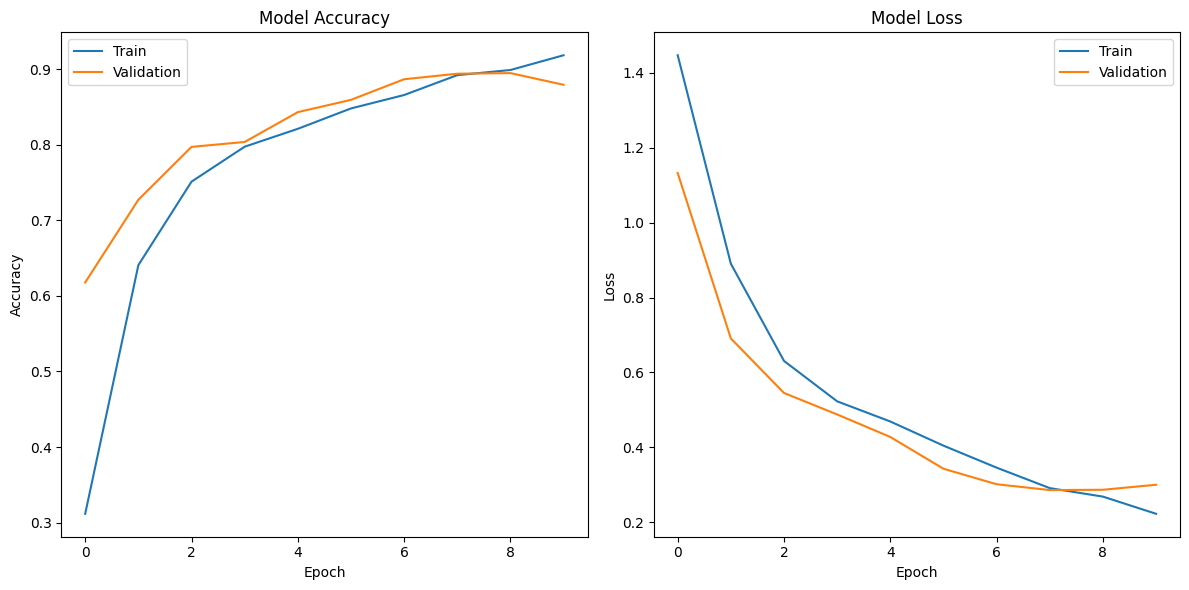

In [33]:
# Plot training history
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [43]:
import os
print("Current Working Directory:", os.getcwd())


Current Working Directory: c:\Users\komal\OneDrive\Desktop


In [44]:
import os

filepath = r'C:\Users\komal\OneDrive\Desktop\best_weights.h5.keras'

# Check if the file exists
if os.path.isfile(filepath):
    print("File exists.")
else:
    print("File does not exist.")


File exists.


In [46]:
from tensorflow.keras.models import load_model

model = load_model('C:\\Users\\komal\\OneDrive\\Desktop\\best_weights.h5.keras')


In [47]:
# Model evaluation
train_score = model.evaluate(train_dataset, verbose=1)
test_score = model.evaluate(test_dataset, verbose=1)

# Print training evaluation results
print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)

# Print test evaluation results
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")

31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - accuracy: 0.9254 - loss: 0.2374
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.8954 - loss: 0.2777
Train Loss: 0.2324
Train Accuracy: 92.29%
--------------------
Test Loss: 0.2865
Test Accuracy: 89.47%


Confusion Matrix

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
import numpy as np

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(9, 9))
    sns.heatmap(cm, annot=True, fmt="d", cmap=plt.cm.Blues, cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.show()



def evaluate_model(model, test_dataset, class_names):
    true_labels = []
    predicted_labels = []

    for images, labels in test_dataset:
        predictions = model.predict(images, verbose=False)
        predicted_classes = np.argmax(predictions, axis=1)
        true_classes = np.argmax(labels, axis=1)

        true_labels.extend(true_classes)
        predicted_labels.extend(predicted_classes)

    cm = confusion_matrix(true_labels, predicted_labels)
    print("Confusion Matrix Shape:", cm.shape)
    return cm


    # Print classification report
    print("Classification Report:\n", classification_report(true_labels, predicted_labels, target_names=class_names))

    # Calculate precision, recall, and F1 score
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    f1 = f1_score(true_labels, predicted_labels, average='weighted')

    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

    # Plot confusion matrix
    plot_confusion_matrix(cm, class_names)




Confusion Matrix Shape: (4, 4)


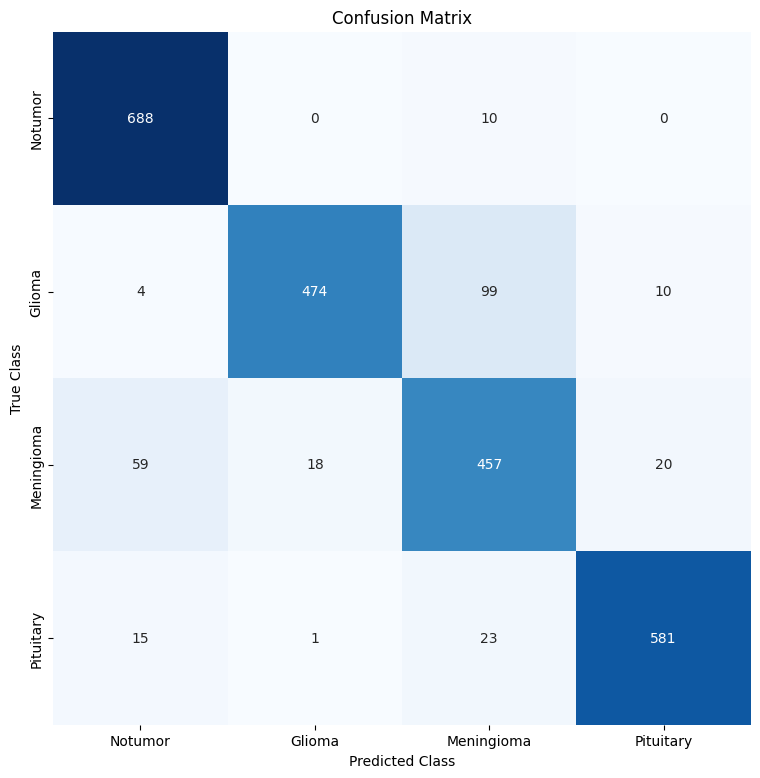

In [54]:
cm = evaluate_model(model, test_dataset, list(tumor_classes.keys()))
plot_confusion_matrix(cm, list(tumor_classes.keys()))

In [56]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: opencv-python in c:\users\komal\appdata\local\programs\python\python311\lib\site-packages (4.10.0.84)




[notice] A new release of pip is available: 23.1.2 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Predicted class

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Predicted class: Notumor


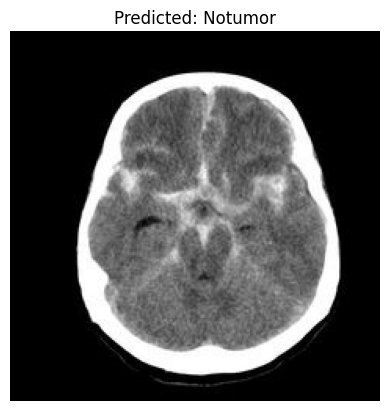

In [59]:
import numpy as np
import tensorflow as tf
import cv2
from tensorflow.keras import models

# Define the path to the image you want to classify
image_path = "C:\\Users\\komal\\Desktop\\brain tumor\\brain tumor dataset\\Testing\\notumor\\Te-no_0053.jpg"  # Replace with the actual image path

# Load the image using OpenCV and preprocess it
def preprocess_image_opencv(image_path, target_size=(150, 150)):
    # Load the image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Resize the image to the target size
    img = cv2.resize(img, target_size)
    # Convert image to float32 and normalize
    img = img.astype('float32') / 255.0
    # Expand dimensions to create a batch of size 1
    img = np.expand_dims(img, axis=0)
    return img

# Preprocess the image
image_tensor = preprocess_image_opencv(image_path)

# Load the trained model
model = load_model('best_weights.h5.keras')  # Replace with the path to your model

# Make a prediction with the loaded model
predictions = model.predict(image_tensor)

# Map the prediction to a class label
class_labels = ['Notumor', 'Glioma', 'Meningioma', 'Pituitary']  # Replace with your class labels
predicted_class = class_labels[np.argmax(predictions)]

# Print the predicted class
print(f'Predicted class: {predicted_class}')
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.title(f'Predicted: {predicted_class}')
plt.axis('off')
plt.show()